# Import Module

In [1]:
import pandas as pd
import numpy as np

# 시각화
import seaborn as sns

# 경고 메시지 무시
import warnings
warnings.filterwarnings(action='ignore') 

import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 
plt.style.use(['ggplot'])

# 사용자 운영체제 확인
import platform
platform.system()

# 운영체제별 한글 폰트 설정
if platform.system() == 'Darwin': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')

plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정

# scaling
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
# clustering
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from mpl_toolkits.mplot3d import Axes3D


# 글씨 선명하게 출력하는 설정
%config InlineBackend.figure_format = 'retina'

# 버전 확인
print('Pandas : %s'%(pd.__version__))
print('seaborn : %s'%(sns.__version__))
print('Sklearn : %s'%(sklearn.__version__))
!python --version

Pandas : 1.4.3
seaborn : 0.11.2
Sklearn : 1.1.2
Python 3.8.8


# Load Data

In [2]:
# 데이터 불러오기
user = pd.read_csv('../data/user_spec.csv')
loan = pd.read_csv('../data/loan_result.csv')
log = pd.read_csv('../data/log_data.csv')

# Preprocessing

- 결측치 처리

    - user_spec

In [3]:
###### birth_year #####
birth_year_mean = user['birth_year'].mean()
user['birth_year'] = user['birth_year'].fillna('없음')

# 전처리할 데이터 재생성
bir = user.groupby('user_id')['birth_year'].apply(set).reset_index()
bir['len'] = bir['birth_year'].apply(lambda x:len(x))

# 0을 지워주는 함수 생성
def remove0(x):
    if len(x) == 2: 
        x_ = x.remove('없음')
        return x_
    else: return x

# 적용
bir['birth_year'].apply(remove0)
bir['year'] = bir['birth_year'].apply(lambda x:list(x)[0])

# 없음을 평균으로 채워줌
bir['year'] = bir['year'].apply(lambda x:birth_year_mean if x == '없음' else x)

# 딕셔너리로 변환하여 저장
birth_year = {x:y for x,y in zip(bir['user_id'], bir['year'])}

# 적용하여 변환
user['birth_year'] = user['user_id'].apply(lambda x:birth_year[x])

In [4]:
###### gender #####
user['gender'] = user['gender'].fillna('없음')

# 전처리할 데이터 재생성
g = user.groupby('user_id')['gender'].apply(set).reset_index()
g['len'] = g['gender'].apply(lambda x:len(x))

# 0을 지워주는 함수 생성
def remove2(x):
    if len(x) == 2: 
        x_ = x.remove('없음')
        return x_
    else: return x

# 적용
g['gender'].apply(remove2)
g['g'] = g['gender'].apply(lambda x:list(x)[0])
g['g'] = g['g'].apply(lambda x:1 if x == '없음' else x)

# 딕셔너리로 변환하여 저장
gender = {x:y for x,y in zip(g['user_id'], g['g'])}

# 적용하여 변환
user['gender'] = user['user_id'].apply(lambda x:gender[x])

In [5]:
#### ersonal_rehabilitation_yn ####
# 기록이 있으면 개인회생자, 없으면 아닌 사람으로 기록
user['personal_rehabilitation_yn'] = user['personal_rehabilitation_complete_yn'].apply(lambda x:1 if x in [0,1] else 0)
# 나머지 기록이 na인 값은 전부 개인회생자가 아닌 것으로 확인함 -> 2( 개인회생자아님 )로 채워줌
user['personal_rehabilitation_complete_yn'] = user['personal_rehabilitation_complete_yn'].fillna(2)

In [6]:
#### company_enter_month ####
# OTHERINCOME을 제외하면 na값이 적기 때문에 입사년도 없음으로 채워줌
user['company_enter_month'] = user['company_enter_month'].fillna('입사년도 없음')

In [7]:
#### credit_score ####
# 신용 점수가 있는 고객들은 해당 고객이 가진 신용 점수의 평균으로 채워줌
user['credit_score'] = user['credit_score'].fillna(user.groupby('user_id')['credit_score'].transform('mean'))

# 평균으로 채워줌
user['credit_score'] = user['credit_score'].fillna(user['credit_score'].mean())

In [8]:
#### existing_loan ####
# existing_loan_cnt와 existing_loan_amt의 수가 na인 값은 0으로 채워줌
user['existing_loan_cnt'] = user['existing_loan_cnt'].fillna(0)
user['existing_loan_amt'] = user['existing_loan_amt'].fillna(0)

In [9]:
#### income ####
# 0으로 채워줌
user['yearly_income'] = user['yearly_income'].fillna(0)
user['income_type'] = user['income_type'].fillna('직장없음')

In [10]:
#### employment_type ####
# 입사년도가 없다는 것은 기타이기 때문에 기타로 채워줌
user['employment_type'] = user['employment_type'].fillna('기타')

In [11]:
#### houseown_type ####
## -> 정보없음으로 채워줌
user['houseown_type'] = user['houseown_type'].fillna('정보없음')

In [12]:
#### desired_amount ####
# 이 경우도 선택을 그냥 하지 않은 경우이기 때문에 최빈값으로 채워줌
## 단순한 궁금증으로 인하여 선택을 한 경우라고 판단 -> 가장 많이 원하는 금액으로 채움
user['desired_amount'] = user['desired_amount'].fillna(user['desired_amount'].mode()[0])

In [13]:
#### purpose ####
# 목적 또한 위와 같음
## 최빈값으로 채움
user['purpose'] = user['purpose'].fillna(user['purpose'].mode()[0])

    - loan_result

In [14]:
# 중복 제거하여 데이터 선언
loan = loan.drop_duplicates()

In [15]:
#### loan_rate ####
# 일부 행만 null인 경우 결측치를 product별 평균
product_list = loan[loan['loan_limit'].isna()]['product_id'].unique()

for i in product_list:
    len_rate = loan[loan['product_id'] == i]['loan_rate'].unique()
    
    if len(len_rate) > 1:
        loan.loc[(loan['product_id'] == i) & (loan['loan_rate'].isna()), 'loan_rate'] = round(np.nanmean(len_rate), 1)

        
# 모두 null인 경우 결측치를 application별 평균
loan['loan_rate'] = loan['loan_rate'].fillna(loan.groupby('application_id')['loan_rate'].transform('mean'))

# application이 하나인 데이터 최빈값 대체
loan['loan_rate'] = loan['loan_rate'].fillna(loan['loan_rate'].mode()[0])

In [16]:
#### loan_limit ####
# loan_limit 결측치를 application별로 평균
loan['loan_limit'] = loan['loan_limit'].fillna(loan.groupby('application_id')['loan_limit'].transform('mean'))

# application이 하나인 결측치 최빈값으로
loan['loan_limit'] = loan['loan_limit'].fillna(loan['loan_limit'].mode()[0])

    - log

In [17]:
# os의 결측치는 최빈값으로 채워줌
log['mp_os'] = log['mp_os'].fillna(log['mp_os'].mode()[0])
# 기본 값이 str이었기 때문에 알수 없는 정보는 없음으로 채움
log['mp_app_version'] = log['mp_app_version'].fillna('없음')

# Clusering

- RFM with Finda

In [18]:
# 이전에 파생변수를 생성했던 데이터를 불러옴
data = pd.read_csv('../data/make_feature.csv')

    - 데이터 모두에 존재하는 고객 29만명에 대하여 분석 진행

In [19]:
# 데이터 모두에 있는 user만 분석에 사용 및 저장
user_id = user[user['user_id'].isin(set(log['user_id'])&set(data['user_id']))]['user_id'].unique()

# log와 user데이터에 있는 공통된 user들만 데이터로 사용
user = user[user['user_id'].isin(user_id)]
log = log[log['user_id'].isin(user_id)]
data = data[data['user_id'].isin(user_id)]

In [20]:
# 타입 변경
log['date_cd'] = pd.to_datetime(log['date_cd'])

    - RFM을 finda에 맞게 변형하여 생성

In [21]:
# recency 계산
recency = log.groupby('user_id')['date_cd'].max().reset_index()

# 2022년3월1일을 기준으로 최근에 방문한 고객의 점수가 높도록 해줌
recency['Recency'] = (recency['date_cd'] - pd.to_datetime('20220301')).dt.days

# frequency 계산
## 단순히 Frequency가 아닌 finda에 최적화된 변수를 찾기 위해 대출 조회하기 버튼을 누른 횟수로 Frequency를 지정
frequency = log[log['event'] == 'OpenApp'].groupby('user_id')['event'].count().reset_index()
frequency.columns = ['user_id', 'Frequency']

# recency와 frequency를 병합후 보정
rfm = pd.merge(recency, frequency, on='user_id', how='left')[['user_id', 'Recency', 'Frequency']]
rfm['Frequency'] = rfm['Frequency'].fillna(0)

# Monetary대신 신용 등급을 넣어줌
rfm = pd.merge(rfm,user.groupby('user_id')['credit_score'].mean().reset_index(), on='user_id', how='left')

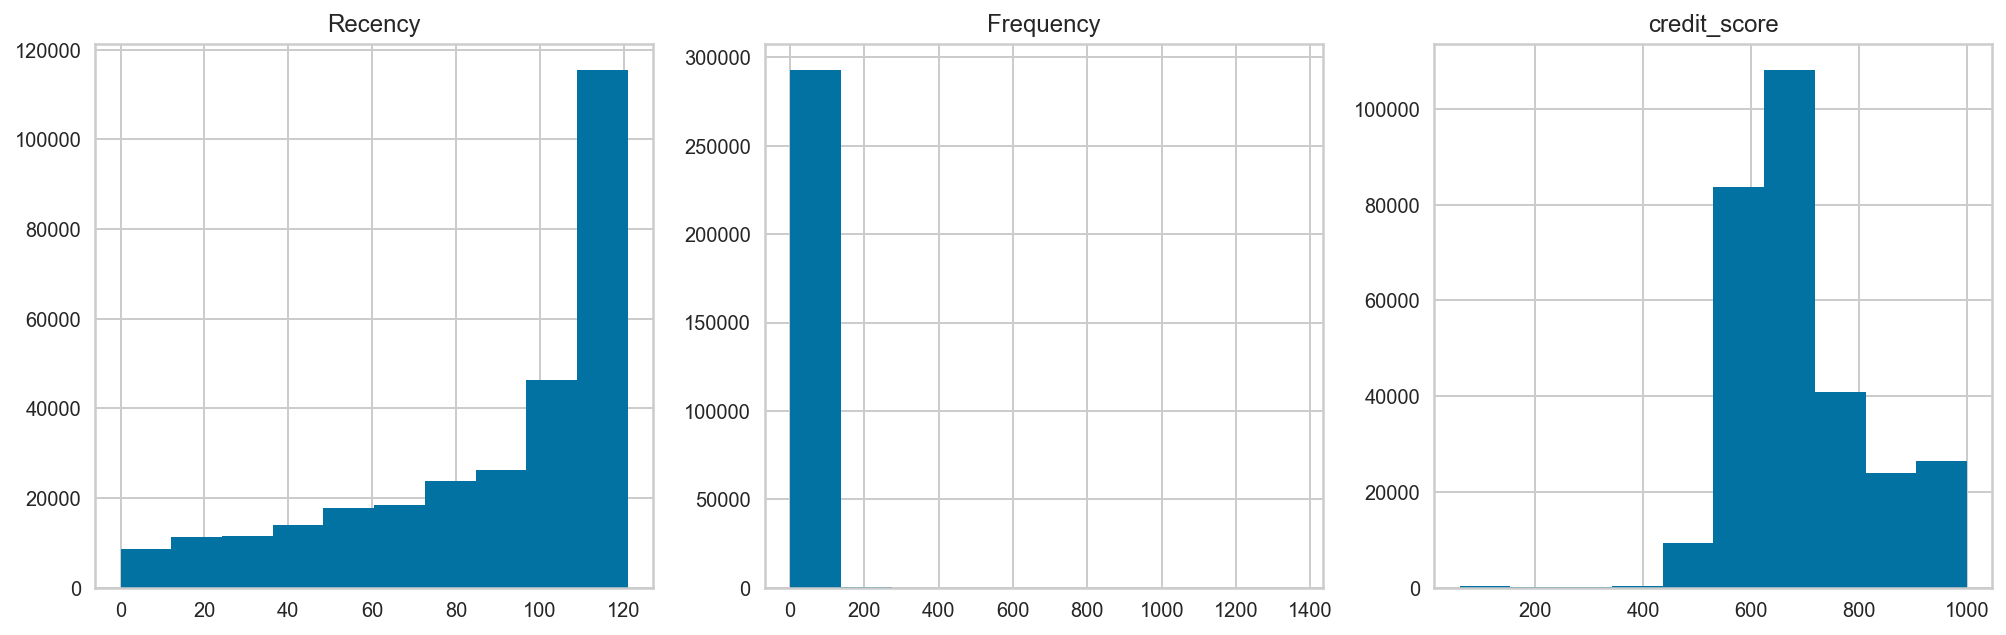

In [22]:
# 시각화를 통해 분포 확인
plt.figure(figsize=(17,5))
plt.subplot(1, 3, 1)
plt.hist(rfm['Recency'])
plt.title('Recency')

plt.subplot(1, 3, 2)
plt.hist(rfm['Frequency'])
plt.title('Frequency')

plt.subplot(1, 3, 3)
plt.hist(rfm['credit_score'])
plt.title('credit_score')
plt.show()

In [23]:
# 스케일링한 후 데이터프레임으로 저장
## 이상치가 존재하는 분포로 이루어져있기 때문에 RobustScaler를 사용함
scaler = StandardScaler()
rfm_scaled = pd.DataFrame(scaler.fit_transform(rfm.iloc[:,1:]))
# 컬럼명을 변경해줌
rfm_scaled.columns = ['Recency', 'Frequency', 'credit_score']
# user_id에 대한 정보를 삽입해줌
rfm_scaled.insert(0, 'user_id', rfm['user_id']);rfm_scaled

,user_id,Recency,Frequency,credit_score
0,9,-0.220843,-0.541237,0.993080
1,11,0.475164,-0.236363,-0.202462
2,14,0.989604,-0.541237,-0.396241
3,17,-2.490431,-0.358313,-1.195370
4,19,-0.432671,-0.541237,-0.396241
...,...,...,...,...
293511,879691,-2.278603,0.373384,-0.546940
293512,879692,-1.007634,-0.236363,0.830973
293513,879693,0.959342,0.007536,-0.157882
293514,879695,-0.039276,-0.541237,-0.396241


- kmeans

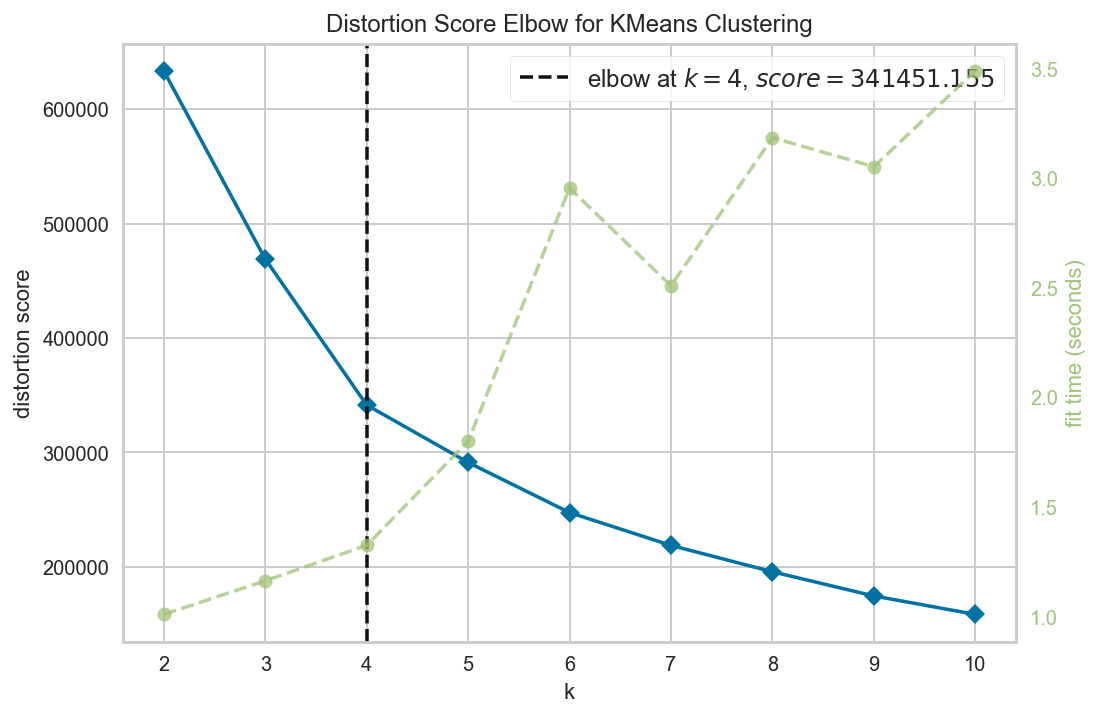

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [24]:
kmeans = KMeans(random_state=np.random.RandomState(seed=42))

elb_visualizer = KElbowVisualizer(kmeans, k=(2,11))
elb_visualizer.fit(rfm_scaled.iloc[:,1:])
elb_visualizer.show()

- 실루엣 계수

In [25]:
# # 오래걸림
# model_5clust = KMeans(n_clusters = 5, random_state=np.random.RandomState(seed=42))

# sil_visualizer = SilhouetteVisualizer(model_5clust)
# sil_visualizer.fit(rfm_scaled.iloc[:,1:])
# sil_visualizer.show()

- 시각화

In [26]:
# 최종 모델로 군집화 후 결과 추출
model_5clust = KMeans(n_clusters = 5, random_state=np.random.RandomState(seed=42))
cluster = model_5clust.fit_predict(rfm_scaled.iloc[:,1:])

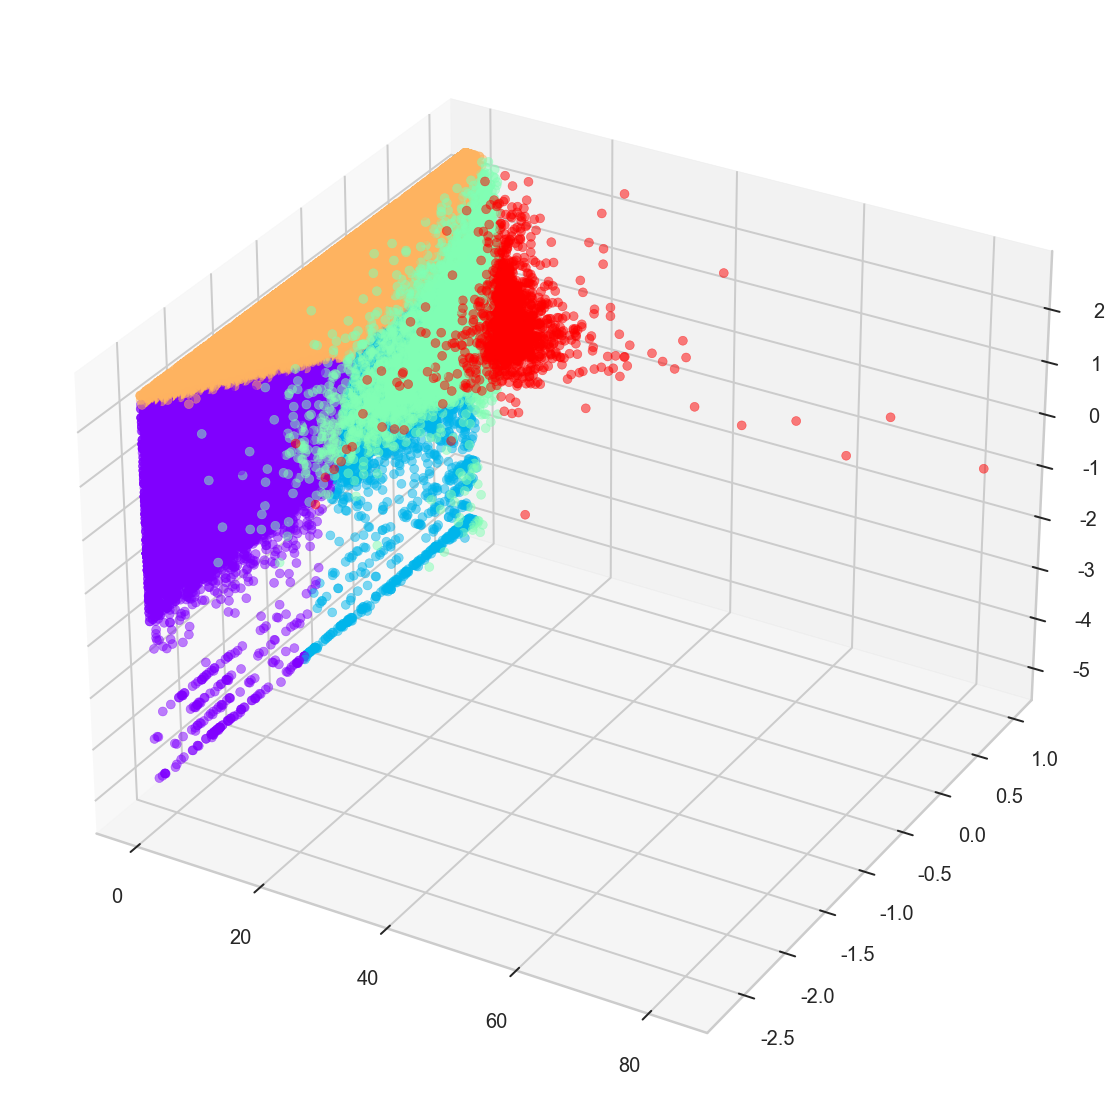

In [27]:
# 3차원 시각화로 군집 확인
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d') 

x = rfm_scaled['Frequency']
y = rfm_scaled['Recency']
z = rfm_scaled['credit_score']
ax.scatter(x, y, z, c = cluster, s= 20, alpha=0.5, cmap='rainbow')
plt.show()

    - cluster에 따른 사용자 수 확인

In [28]:
pd.DataFrame(cluster).value_counts()

1    142320
0     66785
3     58350
2     24470
4      1591
dtype: int64

# Cluster Analysis

In [29]:
# 고객에게 label을 할당
rfm_scaled['labels'] = cluster

# user의 label을 저장해놓음
user_labels = {u_id:label for u_id,label in zip(rfm_scaled['user_id'], rfm_scaled['labels'])}

- Data Load

In [30]:
# user_id별로 label을 할당함
data['labels'] = data['user_id'].apply(lambda x:user_labels[x])

#### 유형별 특징 분석

In [34]:
data[['user_id', 'loan_history']].drop_duplicates(subset='user_id')

,user_id,loan_history
0,430982,0
35,345273,0
36,3058,0
50,181137,0
76,197454,0
...,...,...
13526695,564079,0
13526785,364214,0
13526837,77460,0
13527095,876482,0


## END